<h1 align="center" style="background-color:#616161;color:white">Next Play Analysis</h1>

In [2]:
# import modules
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import datetime
import time
import csv
import json
import sqlite3
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import logging
from ggplot import *

## Parameters you can change

# Abs path to settings file
root = "C:/DS/Github/MusicRecommendation"  # BA, Windows
#root = "/home/badrul/Documents/github/MusicRecommendation" # BA, Linux

## Import the codebase module
fPath = root + "/1_codemodule"
if fPath not in sys.path: sys.path.append(fPath)

import coreCode as cb
import lastfmCode as fm

## Finish setting up
os.chdir(root)

settingsDict =  cb.loadSettings()

dbPath = root + settingsDict['mainDbPath']
fmSimilarDbPath = root + settingsDict['fmSimilarDbPath']
fmTagsDbPath = root + settingsDict['fmTagsDbPath']
trackMetaDbPath = root + settingsDict['trackmetadata']


<h3 style="background-color:#616161;color:white">0. Define the 'start' of a listening session</h3>

In [3]:
# Interval in minutes since the previous listening time is
NewSessIntervalTime = 10

<h3 style="background-color:#616161;color:white">1. Overall picture of when people start listening to music</h3>

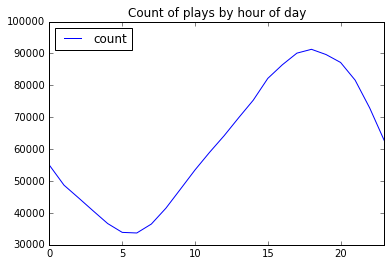

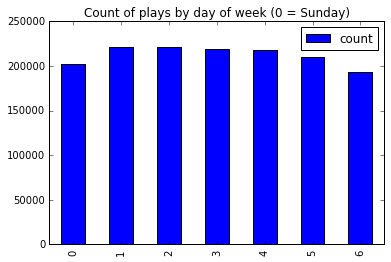

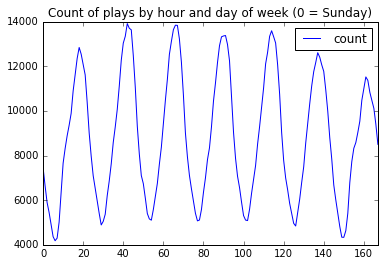

In [4]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(dbPath)
hours = pd.read_sql_query("Select strftime('%H',PlayedTimestamp) as hourOfWeek, count(PlayedTimestamp)  as count  from tblMain where MinsSincePrevPlay > {} group by hourOfWeek".format(NewSessIntervalTime), con)
week = pd.read_sql_query("Select strftime('%w',PlayedTimestamp) as hourOfWeek, count(PlayedTimestamp)  as count  from tblMain where MinsSincePrevPlay > {} group by hourOfWeek".format(NewSessIntervalTime), con)
hrwk = pd.read_sql_query("Select TimeSlot, count(PlayedTimestamp)  as count  from tblMain where MinsSincePrevPlay > {} group by TimeSlot".format(NewSessIntervalTime), con)
con.close()

hours.plot(title='Count of plays by hour of day')
week.plot.bar(title='Count of plays by day of week (0 = Sunday)')
hrwk.plot(title='Count of plays by hour and day of week (0 = Sunday)')

<b>Conclusion</b>

* People listen to music more during the week than on weekends
* There is a predictable pattern to the time of day that people listen to music, at leasat at this aggregate level
* Daytime hours are the most popular time to listen to music, peaking in the early evening / after-work hours

<h3 style="background-color:#616161;color:white">2. User level analysis</h3>

In [5]:
con = sqlite3.connect(dbPath)
con.row_factory = sqlite3.Row
cursor = con.cursor()

sqlStr = "Select UserID, TimeSlot, count(PlayedTimestamp)  as StartCount  from tblMain where MinsSincePrevPlay > {} group by UserID, TimeSlot".format(NewSessIntervalTime)
df = pd.read_sql_query(sqlStr, con)

con.close()

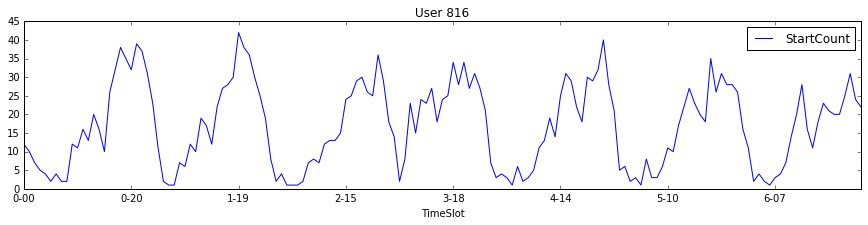

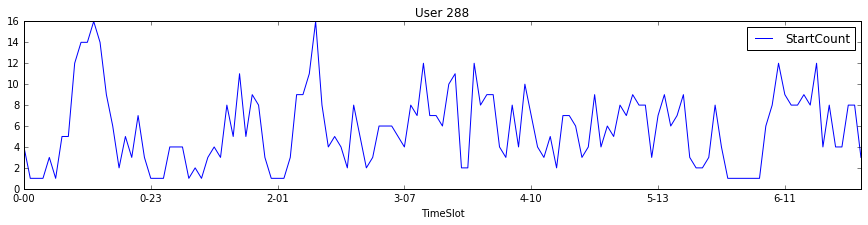

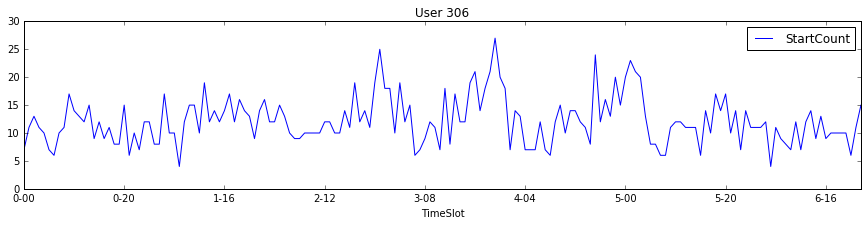

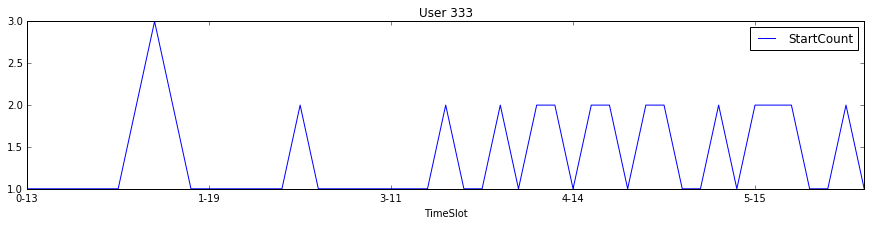

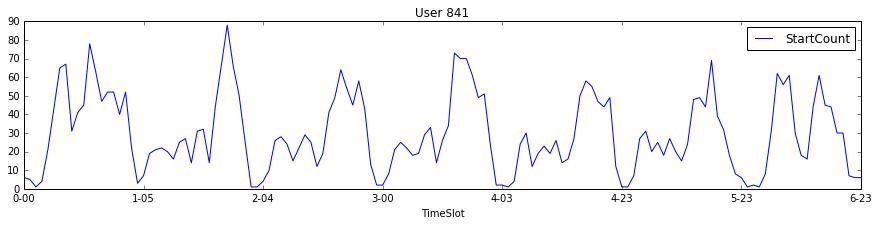

In [6]:
import random
userIDs = random.sample(range(1, 1000), 4)  # Select 4 random userIDs
#or
userIDs = [816,288,306,333,841]

for i in userIDs:
    d = df[df.UserID == i]
    d.plot(x='TimeSlot', y='StartCount', title = 'User {}'.format(i),figsize=[15,3])

As we can see from this small sample , while most users do tend to have specific times of during the week they tend to listen to music, for some users such as user 306 there is quite a bit of variance.

<h4 style="background-color:#616161;color:white">How many weeks before users demonstrate a pattern?</h4>

In [7]:
import time

con = sqlite3.connect(dbPath)
con.row_factory = sqlite3.Row
cursor = con.cursor()

HistIDMax = 2000

sqlStr = "Select UserID, strftime('%d-%m-%Y',PlayedTimestamp) as PlayedDate, TimeSlot, count(PlayedTimestamp)  as StartCount  from tblMain where MinsSincePrevPlay > {} and HistoryID <= {} group by UserID, PlayedTimestamp, TimeSlot".format(NewSessIntervalTime,HistIDMax)
df = pd.read_sql_query(sqlStr, con)
con.close()

In [8]:
df['CCount'] = df.groupby(['UserID','TimeSlot'])['StartCount'].cumcount()+1
df['SCount'] = df.groupby(['UserID'])['StartCount'].cumcount()+1

In [9]:
df.head()

,UserID,PlayedDate,TimeSlot,StartCount,CCount,SCount
0,1,13-08-2006,0-14,1,1,1
1,1,15-08-2006,2-12,1,1,2
2,1,15-08-2006,2-13,1,1,3
3,1,15-08-2006,2-14,1,1,4
4,1,16-08-2006,3-10,1,1,5


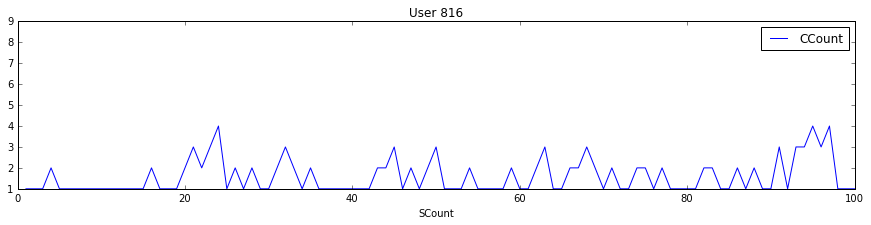

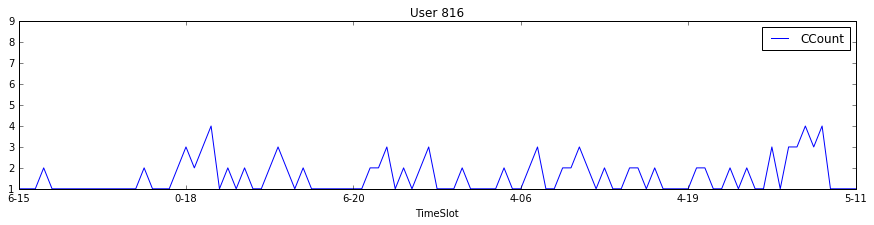

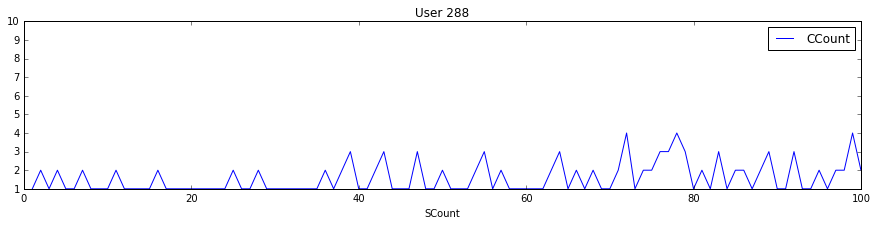

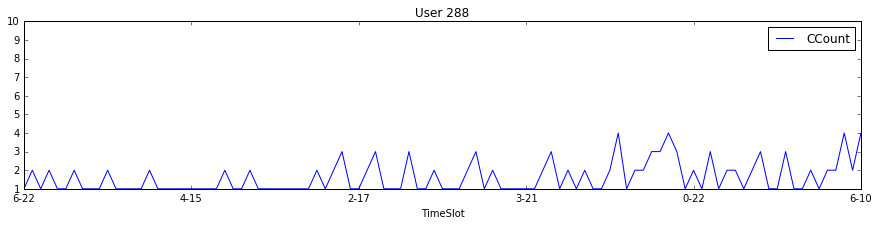

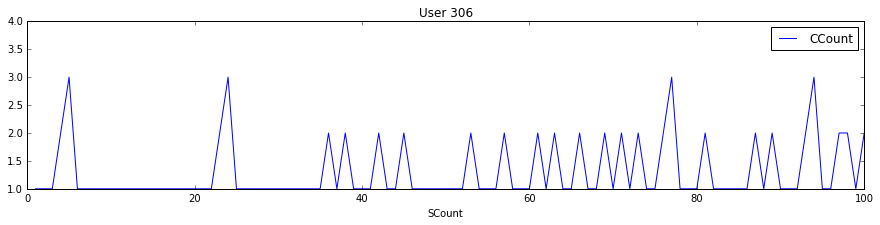

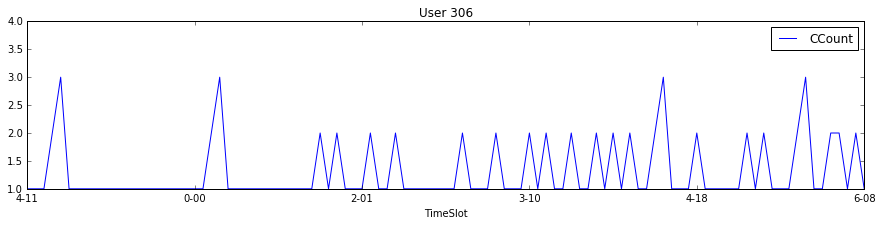

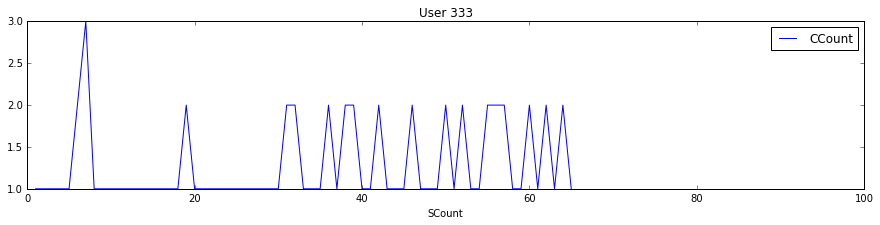

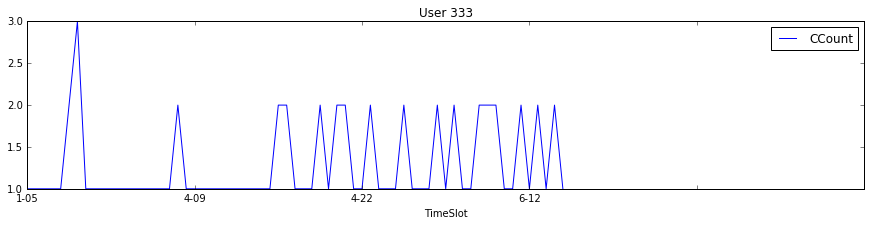

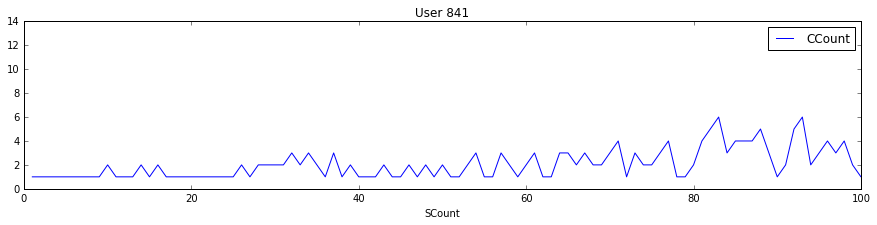

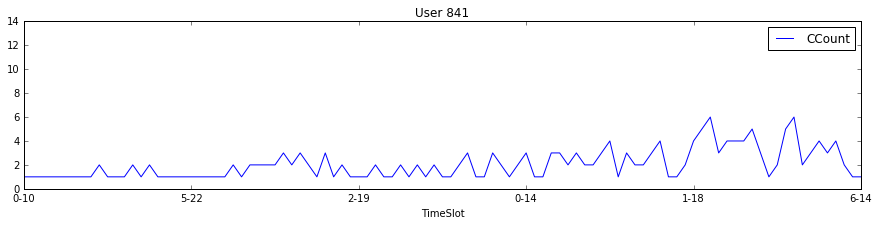

In [10]:
from ggplot import *
userIDs = random.sample(range(1, 1000), 4)  # Select 4 random userIDs
#or
userIDs = [816,288,306,333,841]

for i in userIDs:
    d = df[df.UserID == i]
    d.plot(x='SCount', y='CCount', title ='User {}'.format(i),figsize=[15,3],xlim=[0,100])
    ax=d.plot(x='TimeSlot', y='CCount', title ='User {}'.format(i),figsize=[15,3],xlim=[0,100])
    
#p = ggplot(d,aes(x='SCount', y='CCount'))  + geom_line() #+ facet_wrap("UserID")
#p